**Implementation of Machine Learning in Engineering Drawings**
--------------------------------------------------

Based on experience in material calculations or estimates that are carried out both before starting the project and while the project is in progress, material estimation plays an important role in the time and cost of a project. and human effort or estimator does a lot of looping work and still high error value when doing detection symbols or estimation processes. 

**The Project Goals**
---------------------
    1. Use of OCR for detection of Symbol and then associating them with their respective symbols.
    2. Detection of Symbols in dataset train dan prediction
    3. Human Effort Reduction
    4. Minimizing human error

###**Import Library**

In [ ]:
%matplotlib inline 
import numpy as np # linear algebra
import pandas as pd #CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from random import randint
# imports for  and plotting
import matplotlib
matplotlib.use('agg')
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score


from subprocess import check_output
%matplotlib inline
# hide warnings 
import warnings
warnings.filterwarnings('ignore')

# solve cudNN initialisation 
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df =pd.read_csv('/content/drive/MyDrive/data/Symbols_pixel.csv')

df.tail()


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,255.7431,255.7432,255.7433,255.7434,255.7435,255.7436,255.7437,255.7438,255.7439,Arrowhead
2426,0,0,0,0,0,0,0,0,255,255,...,255,255,255,255,255,255,255,255,255,Valve Slab Gate
2427,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Vessel
2428,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Vessel
2429,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Vessel
2430,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Vessel


**Data Understanding**

Using the method presented above, a series of P&IDs have been processed and
analysed. This resulted in a collection of symbols that represent different types of
equipment within the drawings. In total, a dataset of 2432 instances representing
39 different type of symbols were compiled. All symbols have been scaled to a
standard size of 100×100 pixels

In [ ]:
df.shape

(2431, 10001)

In [ ]:
# get the number df's columns

num_cols = df.shape[1]

In [ ]:
df.isna().sum()

0            0
0.1          0
0.2          0
0.3          0
0.4          0
            ..
255.7436     0
255.7437     0
255.7438     0
255.7439     0
Arrowhead    0
Length: 10001, dtype: int64

In [ ]:
# generate range of ints for suffixes
# with length exactly half that of num_cols;
# if num_cols is even, truncate concatenated list later
# to get to original list length


rng = range(1, (num_cols))
new_cols = ['p_' + str(i) for i in rng]
new_cols.append('label')
df.columns = new_cols[:num_cols]

df.columns

Index(['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
       ...
       'p_9992', 'p_9993', 'p_9994', 'p_9995', 'p_9996', 'p_9997', 'p_9998',
       'p_9999', 'p_10000', 'label'],
      dtype='object', length=10001)

In [ ]:
# extract labels (all rows, and last column)
n = df.shape[1] # number of columns 
labels =df['label']

features= df.iloc[:,0:n-1]
type(labels)

pandas.core.series.Series

In [ ]:
type(features)

pandas.core.frame.DataFrame

In [ ]:
features.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_9991,p_9992,p_9993,p_9994,p_9995,p_9996,p_9997,p_9998,p_9999,p_10000
0,255,255,255,255,255,255,255,255,255,255,...,255,255,0,0,0,0,0,0,0,0
1,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,255,255,255
2,255,255,255,255,255,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
labels.tail(30)

2401         Valve Plug
2402         Valve Plug
2403    Valve Slab Gate
2404    Valve Slab Gate
2405    Valve Slab Gate
2406    Valve Slab Gate
2407    Valve Slab Gate
2408    Valve Slab Gate
2409    Valve Slab Gate
2410    Valve Slab Gate
2411    Valve Slab Gate
2412    Valve Slab Gate
2413    Valve Slab Gate
2414    Valve Slab Gate
2415    Valve Slab Gate
2416    Valve Slab Gate
2417    Valve Slab Gate
2418    Valve Slab Gate
2419    Valve Slab Gate
2420    Valve Slab Gate
2421    Valve Slab Gate
2422    Valve Slab Gate
2423    Valve Slab Gate
2424    Valve Slab Gate
2425    Valve Slab Gate
2426    Valve Slab Gate
2427             Vessel
2428             Vessel
2429             Vessel
2430             Vessel
Name: label, dtype: object

In [ ]:
labels.unique()

array(['Arrowhead', 'Arrowhead + Triangle', 'Barred Tee', 'Box',
       'Continuity Label', 'Control', 'Control Valve',
       'Control Valve Angle Choke', 'Control Valve Globe', 'DB&BBV',
       'DB&BBV + Valve Check', 'DB&BPV', 'Deluge', 'ESDV Valve Ball',
       'ESDV Valve Butterfly', 'ESDV Valve Slab Gate',
       'Exit to Atmosphere', 'Flange + Triangle', 'Flange Joint',
       'Flange Single T-Shape', 'Injector Point', 'Line Blindspacer',
       'Reducer', 'Rupture Disc', 'Sensor', 'Spectacle Blind',
       'Temporary Strainer', 'Triangle', 'Ultrasonic Flow Meter', 'Valve',
       'Valve Angle', 'Valve Ball', 'Valve Butterfly', 'Valve Check',
       'Valve Gate Through Conduit', 'Valve Globe', 'Valve Plug',
       'Valve Slab Gate', 'Vessel'], dtype=object)

In [ ]:
df.dtypes

p_1         int64
p_2         int64
p_3         int64
p_4         int64
p_5         int64
            ...  
p_9997      int64
p_9998      int64
p_9999      int64
p_10000     int64
label      object
Length: 10001, dtype: object

In [ ]:
labels.shape

(2431,)

In [ ]:
labels.head()

0    Arrowhead
1    Arrowhead
2    Arrowhead
3    Arrowhead
4    Arrowhead
Name: label, dtype: object

In [ ]:
features.shape

(2431, 10000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Columns: 10001 entries, p_1 to label
dtypes: int64(10000), object(1)
memory usage: 185.5+ MB


#### Show some random symbols (EDA)

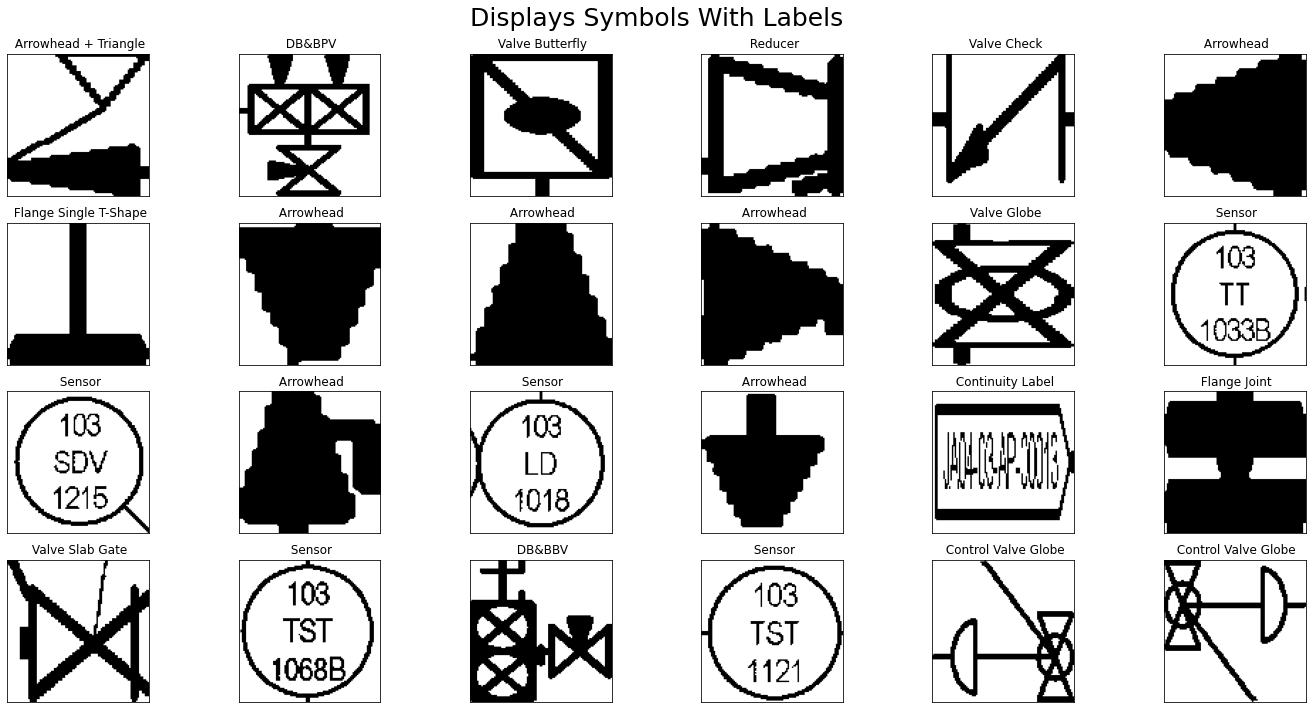

In [ ]:
# Displays Symbols With Labels
fig, ax = plt.subplots(4, 6, figsize=(20, 10))

fx = features.values  # returns numpy array

for i, axi in enumerate(ax.flat):
    value = randint(0, df.shape[0])
    axi.imshow(fx[value].reshape(100, 100), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set(title=f" {labels[value]}")

plt.suptitle('Displays Symbols With Labels', fontsize=25)
plt.tight_layout()
plt.show()

In [ ]:
# Unique Name Symbol

print(len(labels.unique()))

39


#### Class distribution 
* An extremly imbalanced problem 

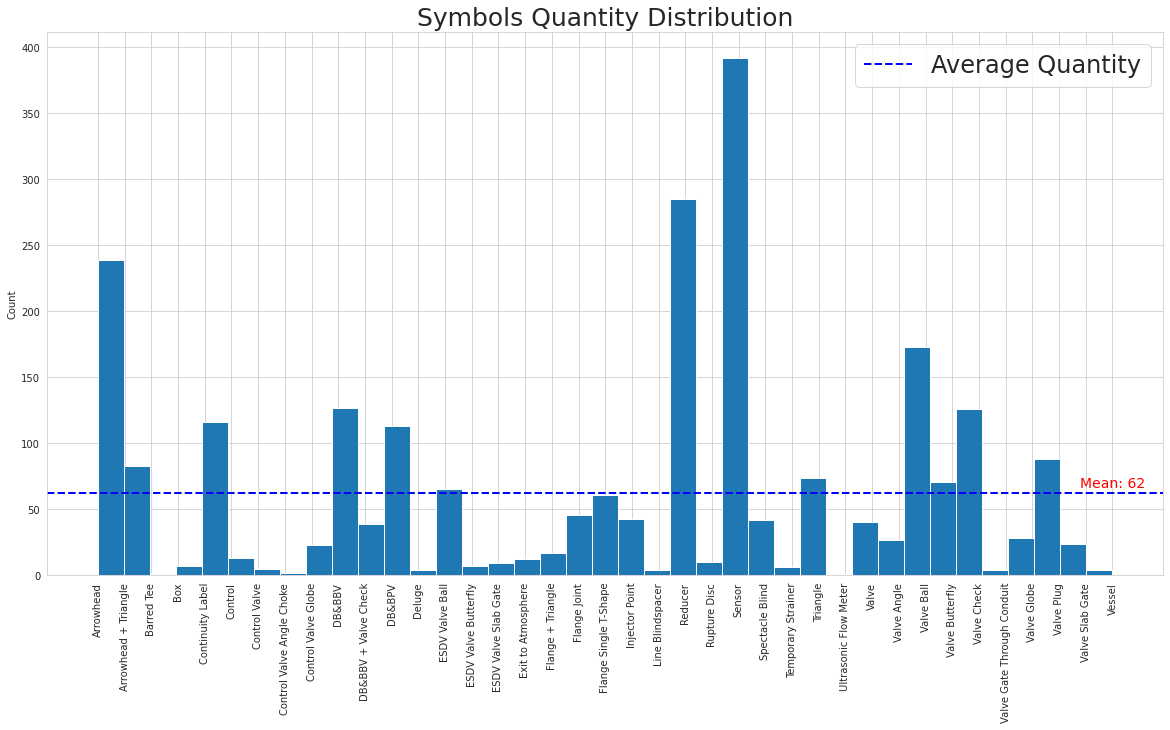

In [ ]:
mean = labels.value_counts().values.mean()

sns.set_style('whitegrid')
plt.figure(figsize=(20,10))

plt.hist(labels, bins=39)
plt.title('Symbols Quantity Distribution', fontsize=25)
plt.ylabel('Count')

plt.axhline(mean, color='b', linestyle='dashed', linewidth=2, label='Average Quantity') # add line avarage
plt.xticks(rotation=90)

plt.text(38, mean+2, f"Mean: {mean:.0f}", fontsize=14, color='r', ha='center', va='bottom') # add labels Avarage 

plt.legend(fontsize=24)
plt.show()

In [ ]:
# Function for Percentage
def display_percent(plot, feature, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 10, ha="center")
    plt.show()

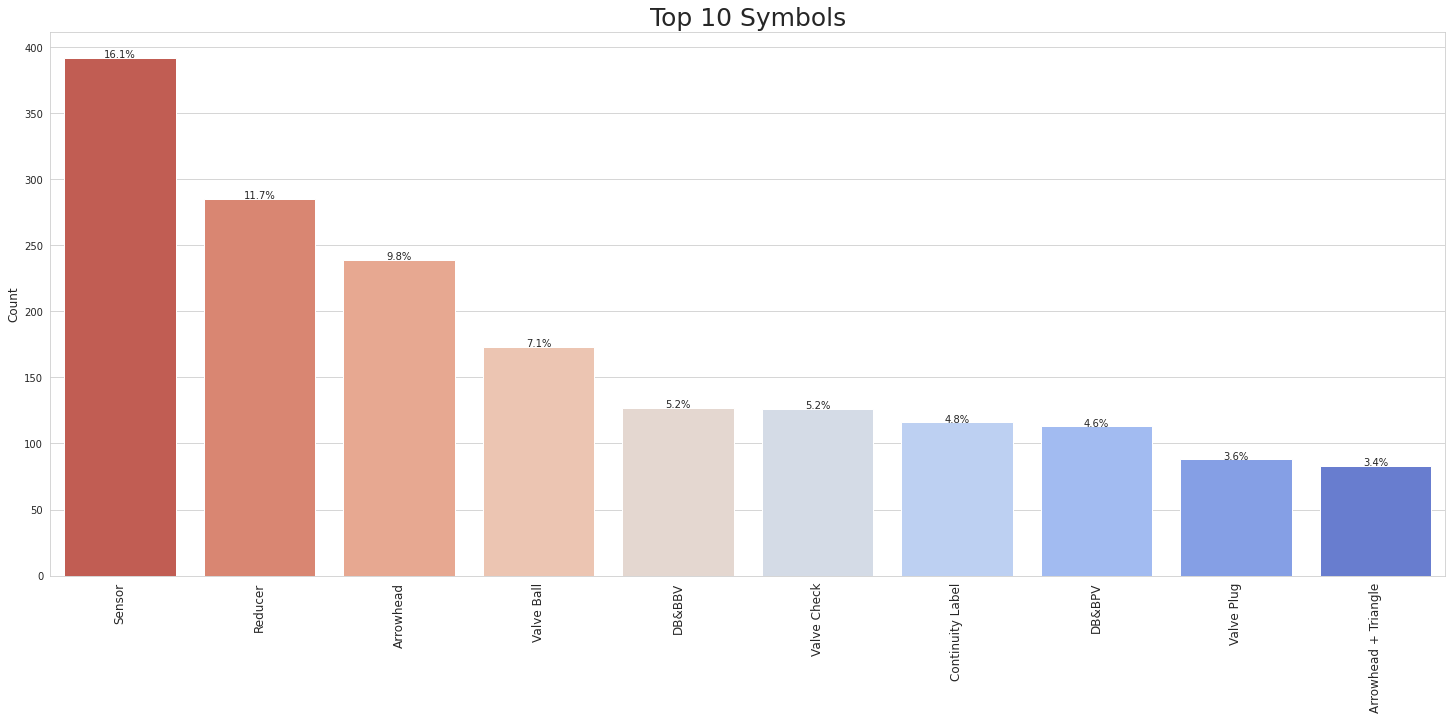

In [ ]:
p = sns.color_palette("coolwarm", 10)
p.reverse()


df_label = pd.DataFrame(labels.value_counts().sort_values(ascending=False))
total = labels.shape[0]
fig, ax = plt.subplots(figsize=(25,10))
sns_label = sns.barplot(x=df_label[:].index, y=df_label[:].values.flatten(), ax=ax, palette=p, order=df_label[:10].index)

plt.xticks(size=12, rotation=90)
plt.title('Top 10 Symbols', size=25, )
plt.ylabel('Count', size=12)

display_percent(ax, df_label, total)

In [ ]:
# Quantity Check Symbols
data = pd.DataFrame({
    'Symbols': labels.value_counts().index,
    'Quantity': labels.value_counts().values
})

display(data)

,Symbols,Quantity
0,Sensor,392
1,Reducer,285
2,Arrowhead,239
3,Valve Ball,173
4,DB&BBV,127
5,Valve Check,126
6,Continuity Label,116
7,DB&BPV,113
8,Valve Plug,88
9,Arrowhead + Triangle,83


### Remove Symbol With less than 7 instances in dataset

In [ ]:
df = df[~df['label'].isin(['Ultrasonic Flow Meter', 'Barred Tee','Temporary Strainer',
                     'Control Valve Angle Choke','Line Blindspacer',
                     'Vessel','Valve Gate Through Conduit','Deluge','Control Valve'])]

In [ ]:
# Quantity Recheck Symbols
data = pd.DataFrame({
    'Symbols': df.label.value_counts().index,
    'Quantity': df.label.value_counts().values
})

display(data)

,Symbols,Quantity
0,Sensor,392
1,Reducer,285
2,Arrowhead,239
3,Valve Ball,173
4,DB&BBV,127
5,Valve Check,126
6,Continuity Label,116
7,DB&BPV,113
8,Valve Plug,88
9,Arrowhead + Triangle,83


In [ ]:
!pip install wordcloud matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

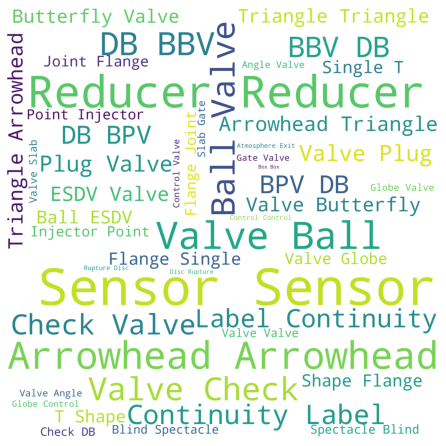

In [ ]:
# Membuat string dari kolom label
text = ' '.join(df['label'].astype(str).tolist())

# Membuat objek WordCloud
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                min_font_size = 16).generate(text)

# Menampilkan WordCloud
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Neural Networks (CNNs)

* Prepare the dataset
* check the shapes 

In [ ]:
# labels and features (separate data frames)
# retrieve numpy array (to meet keras requirements )
dataset = df.values
# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

print(X.shape)
print(y.shape)

(2400, 10000)
(2400,)


In [ ]:
 # check number of labels 
 print(f'There are {len(df.label.unique())} Unique Symbol in the dataset')

There are 30 Unique Symbol in the dataset


#### Prepare the data for the model
* Check the shapes of the input
* Split the data into train/ test subsets 
* Reshape the data 
* Prepare targets (labels)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# simple functions to check the shapes of all compoents of the dataset (train, test, labels)
def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
    
# split the data and check the shapes of results sets  
# train_test_split(...) returns numpy arrays 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
data_summary(X_train,y_train,X_test,y_test)

Train images shape: (1920, 10000)
Train labels shape: (1920,)
Test images shape: (480, 10000)
Test labels shape: (480,)


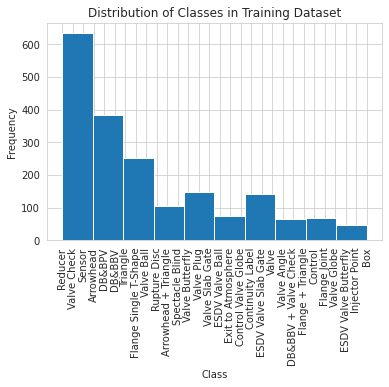

In [ ]:
def plot_histogram(data, title, x_label, y_label):
    plt.hist(data, bins=10)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=90)
    plt.show()

plot_histogram(y_train, 'Distribution of Classes in Training Dataset', 'Class', 'Frequency')


#### Prepare the data for the model
* Reshape the data
* Prepare targets (labels)
* Check shape of the arrays before and after 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

In [ ]:
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 100,100,1)
X_test = X_test.reshape(X_test.shape[0], 100,100,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


print('___ AFTER RESHAPE________')
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
print('X-test ',X_test.shape)
print('y_test ',y_test.shape)

X_train  (1920, 10000)
y_train  (1920,)
X-test  (480, 10000)
y_test  (480,)
___ AFTER RESHAPE________
X_train  (1920, 100, 100, 1)
y_train  (1920,)
X-test  (480, 100, 100, 1)
y_test  (480,)


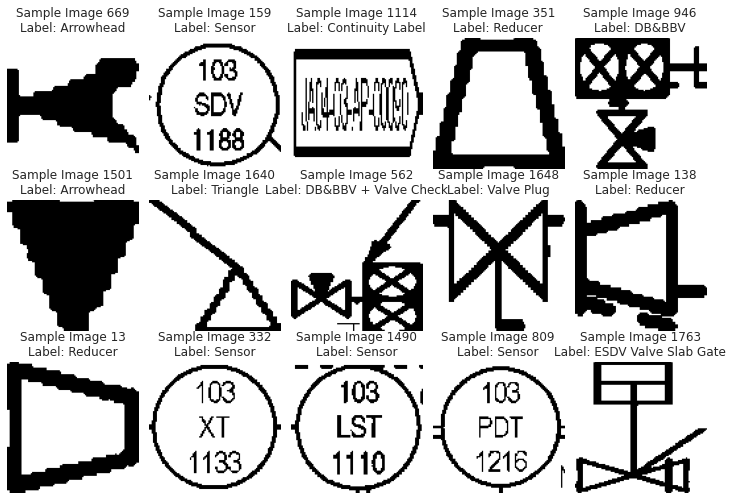

In [ ]:
# visualizing 15 random samples from the training set
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    sample_index = np.random.randint(0, X_train.shape[0])
    ax.imshow(X_train[sample_index], cmap='gray')
    ax.set_title(f"Sample Image {sample_index}\nLabel: {y_train[sample_index]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Prepare the data for the model

* Prepare targets (labels)
* String labels have to be encoded first 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#### Encode Labes Data
* Notice how the shape of the arrays changes 

In [ ]:
# Encode target variables 
# prepare target

y_train_cat = y_train
y_test_cat = y_test

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train,y_test)

print('y_train ',y_train.shape)
print('y_test ',y_test.shape)

y_train  (1920,)
y_test  (480,)


In [ ]:
# print unique label targets before encoding
print('Unique Label Targets Before Encoding:')
print(np.unique(y_train_cat))

# encode label targets
y_train, y_test = prepare_targets(y_train_cat, y_test_cat)

# print unique label targets after encoding
print('Unique Label Targets After Encoding:')
print(np.unique(y_train))

# create dataframe to compare before and after encoding
df = pd.DataFrame({'Original Label': y_train_cat, 'Encoded Label': y_train})
print('\nComparison of Original and Encoded Labels:')
print(df.head(30))

Unique Label Targets Before Encoding:
['Arrowhead' 'Arrowhead + Triangle' 'Box' 'Continuity Label' 'Control'
 'Control Valve Globe' 'DB&BBV' 'DB&BBV + Valve Check' 'DB&BPV'
 'ESDV Valve Ball' 'ESDV Valve Butterfly' 'ESDV Valve Slab Gate'
 'Exit to Atmosphere' 'Flange + Triangle' 'Flange Joint'
 'Flange Single T-Shape' 'Injector Point' 'Reducer' 'Rupture Disc'
 'Sensor' 'Spectacle Blind' 'Triangle' 'Valve' 'Valve Angle' 'Valve Ball'
 'Valve Butterfly' 'Valve Check' 'Valve Globe' 'Valve Plug'
 'Valve Slab Gate']
Unique Label Targets After Encoding:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Comparison of Original and Encoded Labels:
           Original Label  Encoded Label
0                 Reducer             17
1             Valve Check             26
2                  Sensor             19
3               Arrowhead              0
4                 Reducer             17
5                  DB&BPV              8
6                  DB&B

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print('y_train ',y_train.shape)
print('y_test ',y_test.shape)

y_train  (1920, 30)
y_test  (480, 30)


### Validation Set

In [ ]:
# shuffle the training dataset (5 times!)

for _ in range(5): 
    indexes = np.random.permutation(len(X_train))

X_train = X_train[indexes]
y_train = y_train[indexes]

# Keep 10% of the training data for validation 
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(X_train))

# Validation set (val_data)
val_data = X_train[:val_count,:]
val_labels_cat = y_train[:val_count,:]

### Build Model 
* Train, validate and testing sets  

In [ ]:
def build_modelU():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(100, 100, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_modelU()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 128)       7

### Result

In [ ]:
nEpochs = 25 
results = model.fit(X_train, y_train, 
                    epochs=nEpochs, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Epoch 1/25
30/30 [==============================] - 13s 79ms/step - loss: 6.2148 - accuracy: 0.1089 - val_loss: 2.6598 - val_accuracy: 0.3021
Epoch 2/25
30/30 [==============================] - 1s 46ms/step - loss: 2.0564 - accuracy: 0.4557 - val_loss: 1.0529 - val_accuracy: 0.7500
Epoch 3/25
30/30 [==============================] - 1s 41ms/step - loss: 1.3048 - accuracy: 0.6443 - val_loss: 0.6490 - val_accuracy: 0.8542
Epoch 4/25
30/30 [==============================] - 1s 45ms/step - loss: 0.9220 - accuracy: 0.7385 - val_loss: 0.3996 - val_accuracy: 0.9323
Epoch 5/25
30/30 [==============================] - 1s 45ms/step - loss: 0.7761 - accuracy: 0.7870 - val_loss: 0.2951 - val_accuracy: 0.9479
Epoch 6/25
30/30 [==============================] - 1s 44ms/step - loss: 0.6776 - accuracy: 0.8047 - val_loss: 0.2045 - val_accuracy: 0.9479
Epoch 7/25
30/30 [==============================] - 1s 44ms/step - loss: 0.5321 - accuracy: 0.8391 - val_loss: 0.1545 - val_accuracy: 0.9688
Epoch 8/25
3

###check Result

In [ ]:
history_dict = results.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# accuracy, test 
test_loss, test_accuracy = \
  model.evaluate(X_test, y_test, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

8/8 [==============================] - 0s 35ms/step - loss: 0.2753 - accuracy: 0.9625
Test loss: 0.2753 accuracy: 0.9625


### Prediction Test

In [ ]:
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
print('Accuracy: ',sum(preds==actuals)/X_test.shape[0])

15/15 [==============================] - 0s 5ms/step
Accuracy:  0.9625


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_test,axis=1)).sum())

Test accuracy: 0.9624999761581421
15/15 [==============================] - 0s 6ms/step
Incorrectly Identified Symbols:  18


In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

predictions = model.predict(X_train)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_train,axis=1)
#print(confusion_matrix(preds,actuals))

# correctly identified symbols 
print('Incorrectly Identified Symbols: ',(np.argmax(predictions, axis=1) != \
                        np.argmax(y_train,axis=1)).sum())

Train loss: 0.008871822617948055
Train accuracy: 0.9994791746139526
60/60 [==============================] - 0s 6ms/step
Incorrectly Identified Symbols:  1


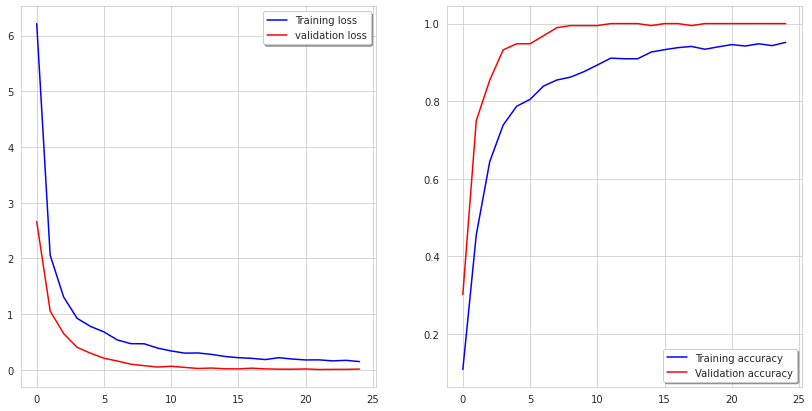

In [ ]:
# Plot the loss and accuracy curves for training and validation 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].plot(results.history['loss'], color='b', label="Training loss")
ax[0].plot(results.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

15/15 [==============================] - 0s 6ms/step


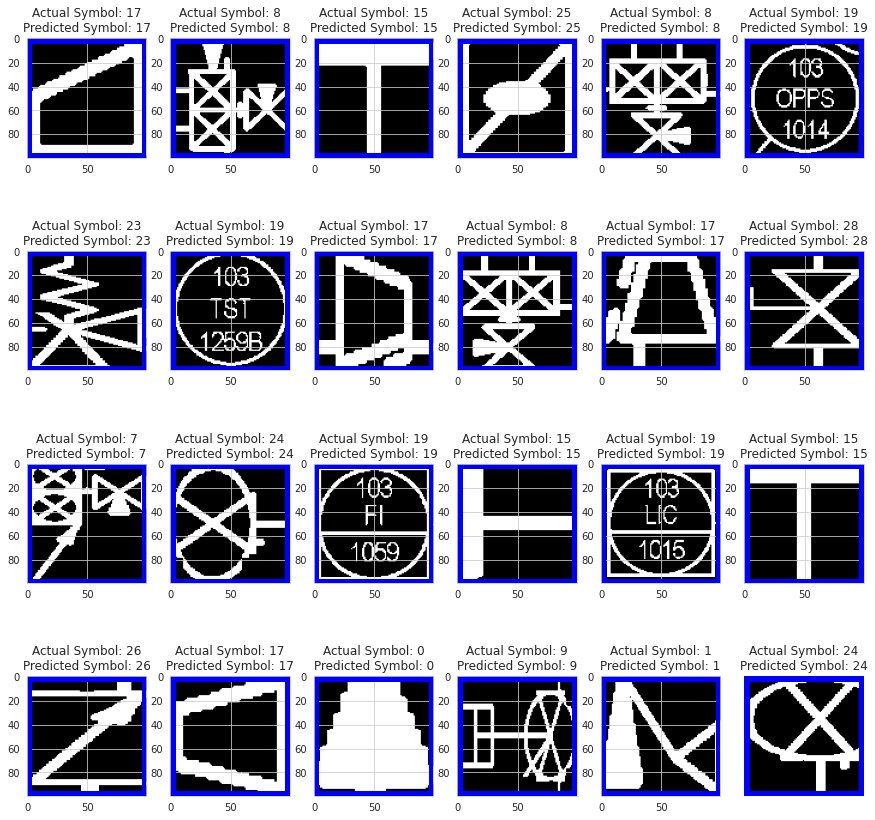

In [ ]:
from matplotlib import patches

y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 100, 100)

fig, axis = plt.subplots(4, 6, figsize=(15, 15))
for i, ax in enumerate(axis.flat):
    # plot image
    ax.imshow(X_test__[i], cmap='binary')
    
    # get actual and predicted label
    actual_label = y_test[i].argmax()
    predicted_label = y_pred[i].argmax()
    
    
    # set title with predicted label and scores
    ax.set(title=f"Actual Symbol: {actual_label}\nPredicted Symbol: {predicted_label}")
    
    # add bbox if prediction is correct
    if actual_label == predicted_label:
        bbox = patches.Rectangle((0,0), 100, 100, linewidth=10, edgecolor='b', facecolor='none')
        ax.add_patch(bbox)
    else:
        bbox = patches.Rectangle((0,0), 100, 100, linewidth=10, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)

    plt.axis('off')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [ ]:
predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=1)
actuals = np.argmax(y_test,axis=1)

print(classification_report(actuals, preds))

15/15 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       1.00      0.80      0.89        20
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.94      0.91      0.92        33
           7       1.00      0.80      0.89        10
           8       0.86      1.00      0.93        25
           9       0.94      1.00      0.97        16
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        14
          16       0.88     

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
nEpochs = 25 
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=64,
    shuffle=True)

val_generator = val_datagen.flow(
    val_data, val_labels_cat,
    batch_size=64,
    shuffle=False)

result_gen = model.fit_generator(
    train_generator,
    steps_per_epoch=X_train.shape[0] // 64,
    epochs=nEpochs,
    validation_data=val_generator,
    validation_steps=val_data.shape[0] // 64,
    callbacks=[early_stop])

Epoch 1/25
30/30 [==============================] - 4s 120ms/step - loss: 2.6841 - accuracy: 0.3323 - val_loss: 1.3116 - val_accuracy: 0.6667
Epoch 2/25
30/30 [==============================] - 2s 71ms/step - loss: 1.3659 - accuracy: 0.6333 - val_loss: 0.3236 - val_accuracy: 0.9583
Epoch 3/25
30/30 [==============================] - 2s 71ms/step - loss: 0.9026 - accuracy: 0.7630 - val_loss: 0.1683 - val_accuracy: 0.9688
Epoch 4/25
30/30 [==============================] - 2s 70ms/step - loss: 0.6741 - accuracy: 0.8094 - val_loss: 0.1340 - val_accuracy: 0.9792
Epoch 5/25
30/30 [==============================] - 2s 69ms/step - loss: 0.5897 - accuracy: 0.8224 - val_loss: 0.0894 - val_accuracy: 0.9792
Epoch 6/25
30/30 [==============================] - 3s 89ms/step - loss: 0.4808 - accuracy: 0.8552 - val_loss: 0.0933 - val_accuracy: 0.9844
Epoch 7/25
30/30 [==============================] - 2s 70ms/step - loss: 0.4248 - accuracy: 0.8714 - val_loss: 0.0738 - val_accuracy: 0.9792
Epoch 8/25
3

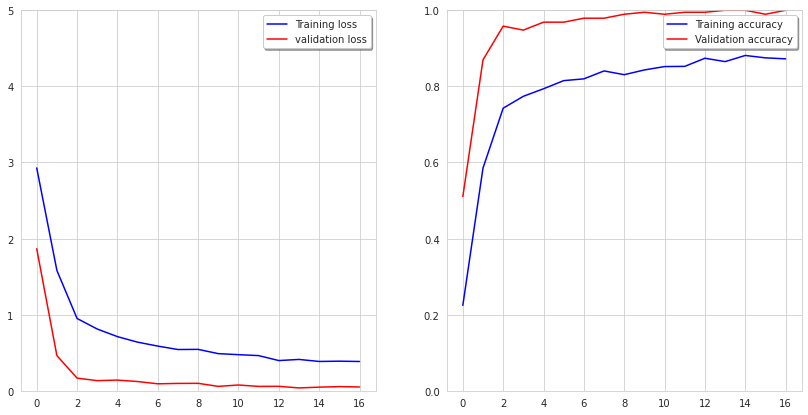

In [ ]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].plot(result_gen.history['loss'], color='b', label="Training loss")
ax[0].plot(result_gen.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_ylim([0, 5])
legend = ax[0].legend(loc='best', shadow=True)


ax[1].plot(result_gen.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(result_gen.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_ylim([0, 1.0])
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

In [ ]:
history_gen = result_gen.history
print(history_gen.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
